In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt

In [ ]:
#import zipfile
#with zipfile.ZipFile("/content/drive/MyDrive/Projects/Hackathon/Data/demand-forecasting-kernels-only(1).zip","r") as zip_ref:
#  zip_ref.extractall("/content/drive/MyDrive/Projects/Hackathon/Data")

In [ ]:
def load_data():  
    return pd.read_csv('/content/drive/MyDrive/Projects/Hackathon/Data/train.csv')  
sales_data = load_data()



In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data


In [ ]:
monthly_df = monthly_sales(sales_data)
monthly_df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


#EDA

In [ ]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(sales_data)


1825 days
5.0 years


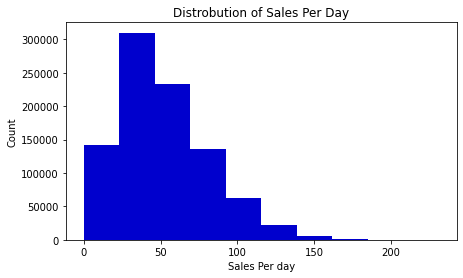

In [ ]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(sales_data.sales, color='mediumblue')
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


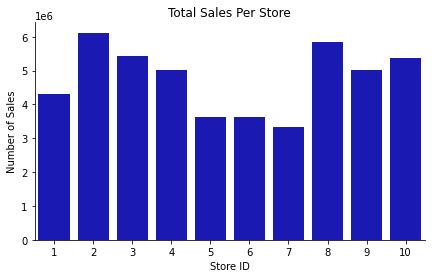

In [ ]:
def sales_per_store():
    by_store = sales_data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

In [ ]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")



Overall average monthly sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


#Determining Stationarity


In [ ]:


def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


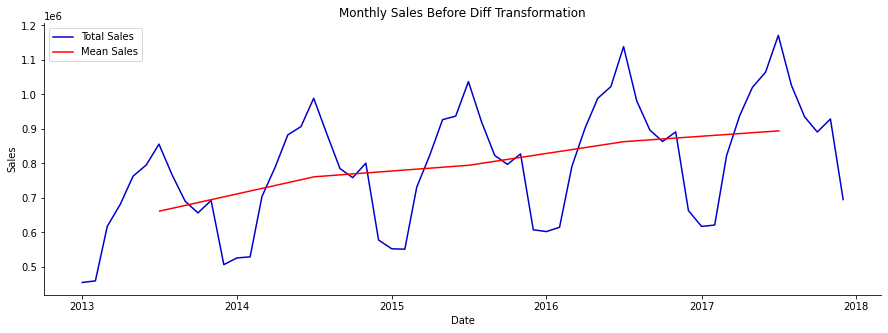

In [ ]:
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [ ]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('/content/drive/MyDrive/Projects/Hackathon/Data/stationary_df.csv')
    return data



In [ ]:
stationary_df = get_diff(monthly_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


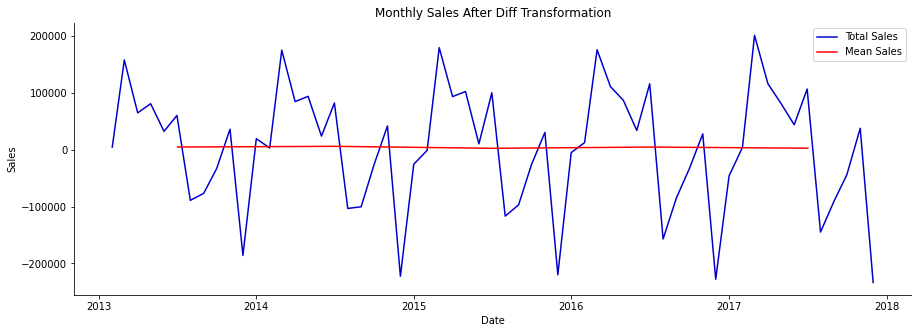

In [ ]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

#Observing Lags


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


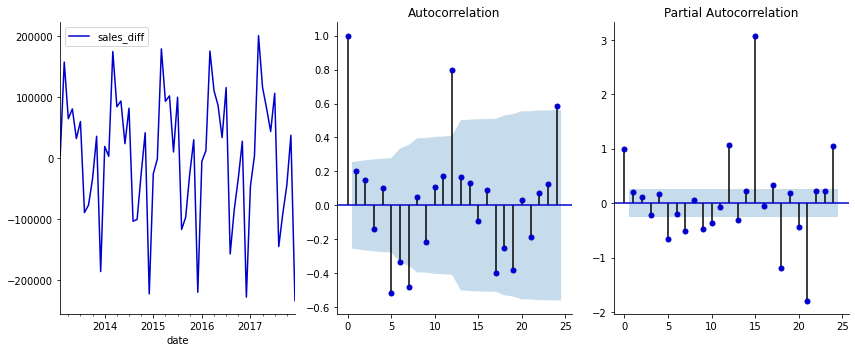

In [ ]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);



#Preparing Dataset Modeling


##Regressive Modeling


In [ ]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('/content/drive/MyDrive/Projects/Hackathon/Data/model_df.csv', index=False)
    
    return supervised_df

In [ ]:
model_df = generate_supervised(stationary_df)

In [ ]:
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


##ARIMA Modeling


In [ ]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('/content/drive/MyDrive/Projects/Hackathon/Data/arima_df.csv')
    
    return dt_data



In [ ]:
datetime_df = generate_arima_data(stationary_df)

In [ ]:
datetime_df

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

# Load Data


In [ ]:
model_df = pd.read_csv('/content/drive/MyDrive/Projects/Hackathon/Data/model_df.csv')

# Train Test Split


In [ ]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)



In [ ]:
train.shape

(35, 13)

In [ ]:
test.shape

(12, 13)

In [ ]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)



In [ ]:
y_train.shape

(35,)

#Modeling Functions


In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted



In [ ]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('/content/drive/MyDrive/Projects/Hackathon/Data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df



In [ ]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [ ]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [ ]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model)



#Linear Regression


RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


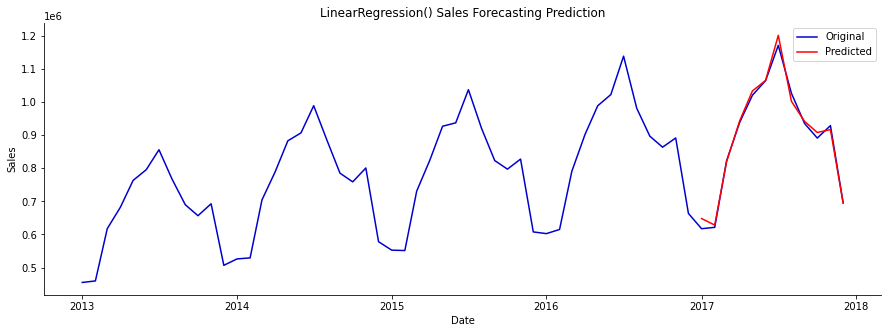

In [ ]:
run_model(train, test, LinearRegression(), 'LinearRegression')

#Random Forest Regressor


RMSE: 17696.626818408076
MAE: 15190.083333333334
R2 Score: 0.9889496010331789


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


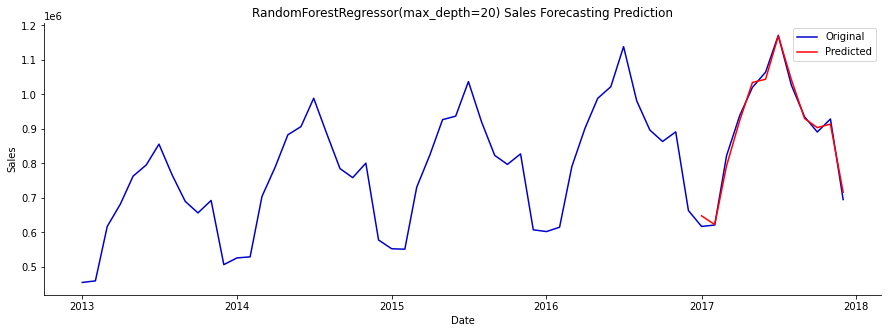

In [ ]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20),'RandomForest')

#XGBoost


RMSE: 13574.792631933646
MAE: 11649.666666666666
R2 Score: 0.9934977542289017


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


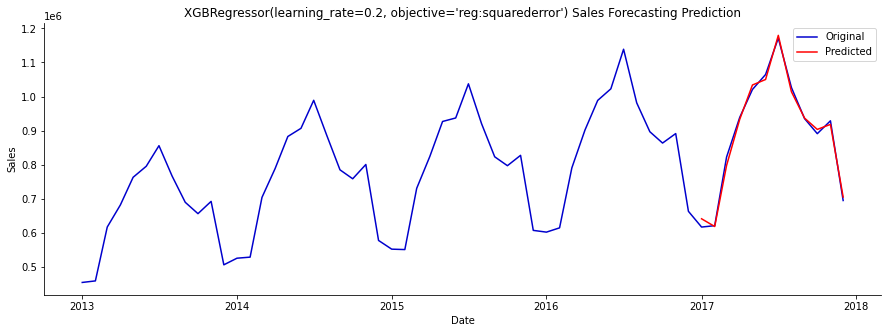

In [ ]:
run_model(train, test, XGBRegressor( n_estimators=100,learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

#LSTM

In [ ]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')



Epoch 1/200
35/35 [==============================] - 5s 5ms/step - loss: 0.4583
Epoch 2/200
35/35 [==============================] - 0s 6ms/step - loss: 0.3924
Epoch 3/200
35/35 [==============================] - 0s 9ms/step - loss: 0.3642
Epoch 4/200
35/35 [==============================] - 0s 10ms/step - loss: 0.3415
Epoch 5/200
35/35 [==============================] - 0s 7ms/step - loss: 0.3226
Epoch 6/200
35/35 [==============================] - 0s 5ms/step - loss: 0.3062
Epoch 7/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2916
Epoch 8/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2781
Epoch 9/200
35/35 [==============================] - 0s 6ms/step - loss: 0.2654
Epoch 10/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2530
Epoch 11/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2408
Epoch 12/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2286
Epoch 13/200
35/35 [================

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


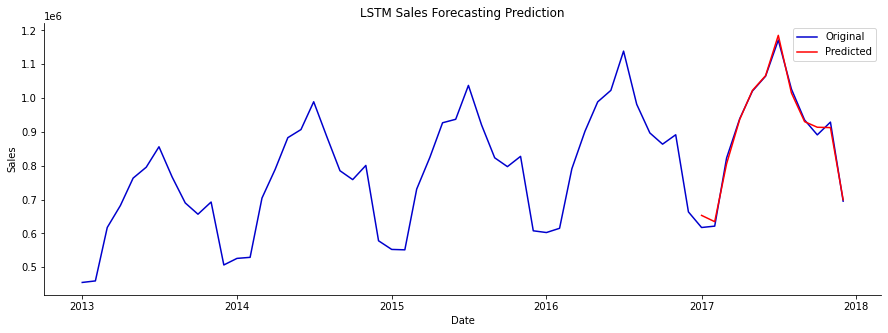

In [ ]:
lstm_model(train, test)

In [ ]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

#Load Data

In [ ]:
def load_data():
    return pd.read_csv('/content/drive/MyDrive/Projects/Hackathon/Data/arima_df.csv').set_index('date')

ts_data = load_data()

In [ ]:
ts_data.index = pd.to_datetime(ts_data.index)

#SARIMAX Modeling


In [ ]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))



In [ ]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 14959.89346608319
MAE: 11265.335748412077
R2 Score: 0.9835642876238073


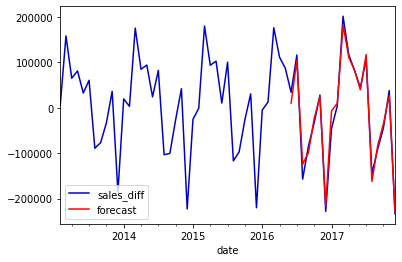

In [ ]:
sar, ts_data, predictions = sarimax_model(ts_data)

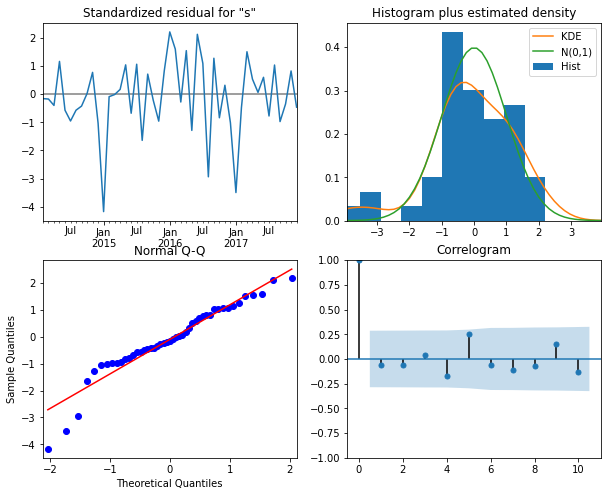

In [ ]:
sar.plot_diagnostics(figsize=(10, 8));

#Plot Results


In [ ]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('/content/drive/MyDrive/Projects/Hackathon/Data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


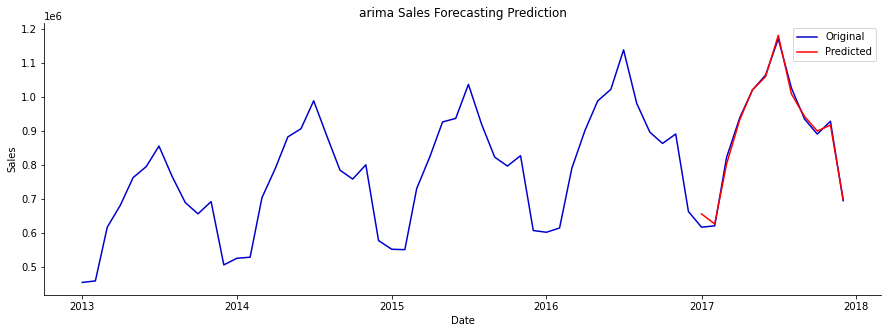

In [ ]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')



We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

#Create Results Dataframe


In [ ]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [ ]:
results = create_results_df()
results

,index,RMSE,MAE,R2
0,RandomForest,17696.626818,15190.083333,0.988950
1,LinearRegression,16221.040791,12433.000000,0.990716
2,LSTM,15536.217893,12053.083333,0.991483
3,ARIMA,14959.893466,11265.335748,0.983564
4,XGBoost,13574.792632,11649.666667,0.993498


#Plot Results


In [ ]:

def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


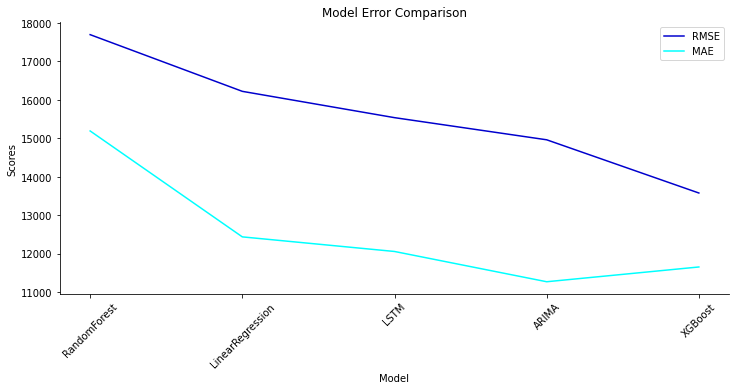

In [ ]:
plot_results(results)

In [ ]:
average_monthly_sales = 894478 #see eda notebook
gboost = 11649.666667
percentage_off = round(gboost/average_monthly_sales*100, 2)

print(f"With XGBoost, prediction is within {percentage_off}% of the actual.")



With XGBoost, prediction is within 1.3% of the actual.


What we see is that overall the XGBoost model had the best performance followed closely by the ARIMA and LSTM models. A caveat here is that all of the models above were derived in their most basic form to demonstrate how they can be used for sales forecasting. The models were only lightly tuned to minimize complexity. The LSTM for example could have many additional nodes and layers to increase performance.

In [ ]:
train

array([[   3130.,   19380., -186036.,   36056.,  -33320.,  -76854.,
         -89161.,   60325.,   32355.,   80968.,   64892.,  157965.,
           4513.],
       [ 175184.,    3130.,   19380., -186036.,   36056.,  -33320.,
         -76854.,  -89161.,   60325.,   32355.,   80968.,   64892.,
         157965.],
       [  84613.,  175184.,    3130.,   19380., -186036.,   36056.,
         -33320.,  -76854.,  -89161.,   60325.,   32355.,   80968.,
          64892.],
       [  93963.,   84613.,  175184.,    3130.,   19380., -186036.,
          36056.,  -33320.,  -76854.,  -89161.,   60325.,   32355.,
          80968.],
       [  23965.,   93963.,   84613.,  175184.,    3130.,   19380.,
        -186036.,   36056.,  -33320.,  -76854.,  -89161.,   60325.,
          32355.],
       [  82168.,   23965.,   93963.,   84613.,  175184.,    3130.,
          19380., -186036.,   36056.,  -33320.,  -76854.,  -89161.,
          60325.],
       [-103414.,   82168.,   23965.,   93963.,   84613.,  175184.,
  